# Analyze A/B Test Results 

This project will assure you have mastered the subjects covered in the statistics lessons. We have organized the current notebook into the following sections: 

- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)



<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.

<a id='probability'></a>
## Part I - Probability


In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline
random.seed(42)

### Data information

user_id: Unique ID  
    
timestamp:Time stamp when the user visited the webpage
    
group: In the current A/B experiment, the users are categorized into two broad groups. The control group users are expected to be served with old_page,
and treatment group users are matched with the new_page. 
    
landing_page: It denotes whether the user visited the old or new webpage.
    
converted: It denotes whether the user decided to pay for the company's product. Here, (1) means yes, the user bought the product.




### 1. importing the dataset and getting basic information about it 

**a.** Read in the dataset from the `ab_data.csv` file and take a look at the top few rows here:

In [3]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


**b.** number of rows in the dataset.

In [8]:
df.shape[0]

294478

**c.** The number of unique users in the dataset.

In [9]:
df.user_id.nunique()

290584

**d.** The proportion of users converted.

In [10]:
(df.converted == 1).mean()

0.11965919355605512

**e.** The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [11]:
(df.query('group == "treatment"').landing_page != 'new_page').sum()

1965

The number of times when the "group" is `control` but "landing_page" is not a `old_page`.

In [12]:
(df.query('group == "control"').landing_page != 'old_page').sum()

1928

In [13]:
# Total page numbers that doesn't match it's right group 
(df.query('group == "treatment"').landing_page != 'new_page').sum() + (df.query('group == "control"').landing_page != 'old_page').sum()

3893

**f.** Do any of the rows have missing values?

In [14]:
df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

#### We don't have any missing values in the rows

### 2. making sure that for each group type meet the right landing page

In [15]:
# Remove the inaccurate rows, and store the result in a new dataframe df2

# 1- make dataframe for users from treatment group and their landing page is new_page
df_treatment = df.query('group == "treatment"')
df_treatment = df_treatment.query('landing_page == "new_page"')

# 2- make dataframe for users from control group and their landing page is old_page
df_control = df.query('group == "control"')
df_control = df_control.query('landing_page != "new_page"')

# 3- merge the dataframes into df2
df2=pd.concat([df_control,df_treatment])

In [16]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

### 3. check if there is duplicated users  

**a.** How many unique **user_id**s are in **df2**?

In [17]:
df2.user_id.nunique()

290584

**b.** There is one **user_id** repeated in **df2**.  What is it?

In [18]:
df2[df2.user_id.duplicated()].index

Int64Index([2893], dtype='int64')

**c.** Display the rows for the duplicate **user_id**? 

In [19]:
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**d.** Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [20]:
# Remove one of the rows with a duplicate user_id..
# Hint: The dataframe.drop_duplicates() may not work in this case because the rows with duplicate user_id are not entirely identical. 
df2.drop(index=df2[df2.user_id.duplicated()].index, inplace= True)

# Check again if the row with a duplicate user_id is deleted or not
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted


### 4.  

**a.** What is the probability of an individual converting regardless of the page they receive?<br><br>



In [21]:
p_popul = (df2.converted == 1).mean()
p_popul

0.11959708724499628

**b.** Given that an individual was in the `control` group, what is the probability they converted?

In [22]:
cont_conv_mean=(df2.query('group == "control"').converted == 1).sum()/df2.query('group == "control"').shape[0]
cont_conv_mean

0.1203863045004612

**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

In [23]:
treat_conv_mean=(df2.query('group == "treatment"').converted == 1).sum()/df2.query('group == "treatment"').shape[0]
treat_conv_mean

0.11880806551510564

In [24]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff = treat_conv_mean - cont_conv_mean
obs_diff

-0.0015782389853555567

**d.** What is the probability that an individual received the new page?

In [25]:
(df2.landing_page == 'new_page').mean()

0.5000619442226688

**e.** based on the results from parts (a) through (d) above.

> 1. based on (d) part we can see that both treatment and control groups are aproximatly the same on reciving each of the page types
>> the data is not baised to any of the sides

> 2. based on the difference between the conversion rates for the two groups
>>the new treatment group users don't lead to more conversions

<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, you could run a hypothesis test continuously as long as you observe the events. 

However, then the hard questions would be: 
- Do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


### 1. Allocating the null and alternative hypothesis


$$H_0: P_{new} - P_{old} <= 0$$
$$H_1: P_{new} - P_{old} > 0$$

### 2. - Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section, i will: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 





**a.** What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

In [26]:
pnew_nul = (df2.converted == 1).sum()/df2.shape[0]
pnew_nul

0.11959708724499628

**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [27]:
pold_nul = (df2.converted == 1).sum()/df2.shape[0]
pold_nul

0.11959708724499628

**c.** What is $n_{new}$, the number of individuals in the treatment group? 

In [29]:
n_new=df2.query('group == "treatment"').shape[0]
n_new

145310

**d.** What is $n_{old}$, the number of individuals in the control group?

In [30]:
n_old=df2.query('group == "control"').shape[0]
n_old

145274

**e. Simulate Sample for the `treatment` Group**<br> 


In [31]:
# Simulate a Sample for the treatment Group
new_page_converted = np.random.choice([0,1],size=n_new, p=[(1-pnew_nul),pnew_nul])
new_page_converted

array([0, 0, 0, ..., 0, 1, 0])

**f. Simulate Sample for the `control` Group** <br>


In [32]:
# Simulate a Sample for the control Group
old_page_converted =np.random.choice([0,1],size=n_old, p=[(1-pold_nul),pold_nul])
old_page_converted

array([0, 0, 0, ..., 0, 0, 0])

**g.** Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for your simulated samples from the parts (e) and (f) above. 

In [33]:
diff= (new_page_converted.sum()/n_new)-(old_page_converted.sum()/n_old)
diff

-1.562329097161419e-05


**h. Sampling distribution** <br>
Re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process you used in parts (a) through (g) above. 

<br>
Store all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [34]:
# Sampling distribution 
# p_diffs = []
# for i in range(10_000):
#     new_page_converted = np.random.choice([0,1],size=n_new, p=[(1-pnew_nul),pnew_nul])
    
#     old_page_converted =np.random.choice([0,1],size=n_old, p=[(1-pold_nul),pold_nul])
#     p_diff= (new_page_converted.sum()/n_new)-(old_page_converted.sum()/n_old)
#     p_diffs.append(p_diff)


# a better solusion to avoid the loop 
# simulating using binomial 

new_page_converted = np.random.binomial(n_new,size=10_000, p=[pnew_nul])

old_page_converted =np.random.binomial(n_old,size=10_000, p=[pold_nul])

p_diff= (new_page_converted/n_new)-(old_page_converted/n_old)


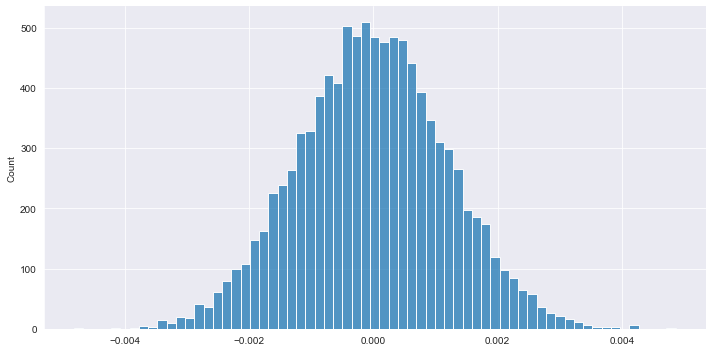

In [37]:
# p_diffs = np.array(p_diffs)
# sns.displot(p_diff, aspect=2)

sns.displot(p_diff, aspect=2)

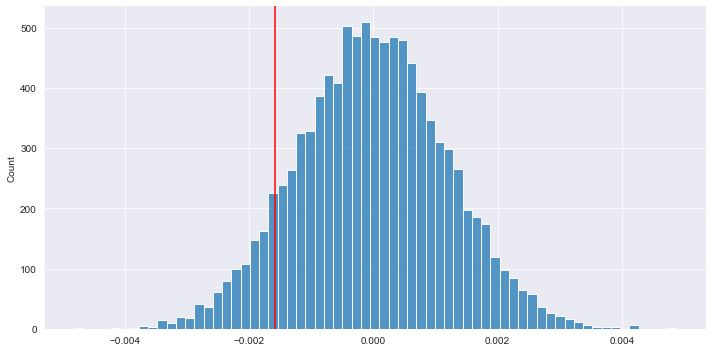

In [38]:
# sns.displot(p_diffs, aspect=2)
sns.displot(p_diff, aspect=2)
plt.axvline(obs_diff, color='r')

**j.** What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

In [40]:
# pval=(p_diffs > obs_diff).mean()
pval=(p_diff > obs_diff).mean()

pval

0.9038

**k.** Please explain in words what you have just computed in part **j** above.  
 - p_value  
 >is the probability of observing your statistic (or one more extreme in favor of the alternative) if the null hypothesis is true.
 - based on a type 1 error rate (0.05)
 >the p_value (0.904) is bigger than the error value (0.05) which mean we will fail to reject the null hypothesis.
 



**l. Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 


In [41]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = df2.query('landing_page == "old_page" and converted == 1 ').shape[0]

# number of conversions with the new_page
convert_new = df2.query('landing_page == "new_page" and converted == 1 ').shape[0]

# number of individuals who were shown the old_page
n_old = n_old

# number of individuals who received new_page
n_new = n_new
z_score, pval=sm.stats.proportions_ztest([convert_new,convert_old], [n_new,n_old], alternative='larger')


In [42]:
print(z_score, pval)

-1.3109241984234394 0.9050583127590245


> p_value from the z_test is approximately the same as the p_value on (j), and both agree with failing to reject the null hypothesis.

<a id='regression'></a>
### Part III - A regression approach

In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

**a.** Since each row in the `df2` data is either a conversion or no conversion

>we will perform a Logistic regression model

**b.** The goal is to use **statsmodels** library to fit the regression model you specified in part **a.** above to see if there is a significant difference in conversion based on the page-type a customer receives. However, first need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [43]:
df2['intercept'] = 1
df2['ab_page']=pd.get_dummies(df2.group).treatment

**c.** Use **statsmodels** to instantiate your regression model on the two columns you created in part (b). above, then fit the model to predict whether or not an individual converts. 


In [44]:
logit_mod = sm.Logit(df2.converted, df2[['intercept', 'ab_page']])
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


**d.** Provide the summary of your model below, and use it as necessary to answer the following questions.

In [45]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2021-11-13 15:06 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

**e.** What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?
> the p-value associated with **ab_page** is the prediction for whether the new page users will do conversion or no

- null hypothesis in the logistic regression model is ab_page = 1 and conversion = 0   and the alternative is if ab_page =1 and the conversion != 0 
> that show us that Part III hypothesis is a two-sided
- part II hypothesis is one-sided

- based on the ab_page p-value 
> the p-value is greater than the type 1 error (0.05) which mean we will fail to reject the null hypothesis



**f.** Now, considering other things that might influence whether or not an individual converts. is it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

>Adding more explanatory variables might help us on better predicting the conversion operation

>but there might happen a multicollinearity if the explanatory variables are correlated with each other.

In [46]:
# Read the countries.csv
df_coun = pd.read_csv('countries.csv')

In [47]:
# Join with the df2 dataframe
df_new =  pd.merge(df2, df_coun, on='user_id', how='outer')

In [48]:
# Create the necessary dummy variables
df_new[pd.get_dummies(df_new.country).columns]= pd.get_dummies(df_new.country)

In [49]:
df_new.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1
2,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1
3,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,0,US,0,0,1
4,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,0,US,0,0,1


In [50]:
# creating the model
logit_mod = sm.Logit(df_new.converted, df_new[['intercept', 'ab_page', 'CA', 'UK']])

#fitting the model
results = logit_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212781.1253
Date:               2021-11-13 15:06 BIC:              212823.4439
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           3                LL-Null:          -1.0639e+05
Df Residuals:       290580           LLR p-value:      0.17599    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9893    0.0089  -223.7628  0.0000  -2.0067  -1.9718
ab_page      -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
CA           -0.0408    0.0269    -1.5161  0.1295  -0.0934   0.0119
UK            0.0099    0.0133     0.7433  0.4573  -0.0162   0.0359
==================================================================

"""

>From the p_values of each variable it seems that there is no significant result show that we can accept the alternative hypothesis

> each p_value is less than type 1 error rate(0.05)

h.
Though we have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if are there significant effects on conversion.  **Create the necessary additional columns, and fit the new model.** 


In [51]:
# adding the interactions between country and page 
df_new['page_CA'] = df_new['ab_page'] * df_new['CA']
df_new['page_UK'] = df_new['ab_page'] * df_new['UK']
df_new['page_US'] = df_new['ab_page'] * df_new['US']

In [54]:
# creating the model
logit_mod = sm.Logit(df_new.converted, df_new[['intercept','ab_page','US','UK','page_US','page_UK']])

# Fitting the model
results = logit_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212782.6602
Date:               2021-11-13 15:08 BIC:              212846.1381
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           5                LL-Null:          -1.0639e+05
Df Residuals:       290578           LLR p-value:      0.19199    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0040    0.0364  -55.0077  0.0000  -2.0754  -1.9326
ab_page       -0.0674    0.0520   -1.2967  0.1947  -0.1694   0.0345
US             0.0175    0.0377    0.4652  0.6418  -0.0563   0.0914
UK             0.0118    0.0398    0.2957  0.7674  -0.0663   0.0899
page_US        0.0469    0.0538    0.8718  0.3833  -0.0585   0.1523
page_UK        0.0783    0.0568    1.3783  0.1681  -0.0330   0.1896
==================================================================

"""

> From above we can see that even after adding interactions, there is no statistically significant result that allow us to reject the null hypothesis,
> Since the p_value of all of the explanatory variables is greater than the type 1 error rate (0.05)

### Conclusion: 

> Based on the results from the different logistic regression models, We didn't find any statistically significant result that allow us to reject the null hypothesis

> Also it is not practically significant to try to launch the new page version

> At the end we will fail to reject the null hypothesis and keep using the old page version. 